## Pertpy cell type priorization with Augur

In [1]:
import scanpy as sc
import pertpy as pt
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3               
sc.logging.print_version_and_date()

# making sure plots & clusters are reproducible
np.random.seed(42)

Running Scanpy 1.10.2, on 2024-09-04 13:06.


In [2]:
## plotting variables
plot_folder = "/media/HDD_1/Michael/Michelangelo/aging/augurpy/"
sc.set_figure_params(vector_friendly = True)
plt.rcParams['figure.figsize'] = (6, 5)
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['pdf.fonttype'] = 42

In [3]:
object_folder = "/media/HDD_1/Janine/Aging_SingleCell/data_objects/"
adata = sc.read(object_folder + "230111_Bleo_Ageing_annotated_final.h5ad") ### 3.9 GB ###

In [4]:
## have a look at the adata object
adata

AnnData object with n_obs × n_vars = 160477 × 29814
    obs: 'age', 'barcode', 'batch', 'day', 'name', 'sex', 'treatment', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'doublet_scores', 'size_factors', 'S_score', 'G2M_score', 'phase', 'time_point', 'leiden_1', 'leiden_2', 'domain', 'cell_type', 'ct_level2', 'compartment_label', 'meta_label', 'age_treatment', 'age_day'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'age_colors', 'age_day_colors', 'age_treatment_colors', 'batch_colors', 'cell_type_colors', 'compartment_label_colors', 'ct_level2_colors', 'day_colors', 'dendrogram_cell_type', 'domain_colors', 'hvg', 'leiden', 'leiden_1_colors', 'leiden_2_colors', 'meta_label_colors', 'name_colors', 'neighbors', 'pca', 'sex_colors', 'time_point_colors', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'unsouped_counts'
    obsp: 'connect

In [6]:
adata.obs.age_day.value_counts()

age_day
young_d0     29048
old_d0       24730
old_d10      13163
old_d20      12281
young_d10    11954
young_d20    11729
young_d30    11099
old_d3       10957
young_d3     10544
old_d30       8915
young_d37     8619
old_d37       7438
Name: count, dtype: int64

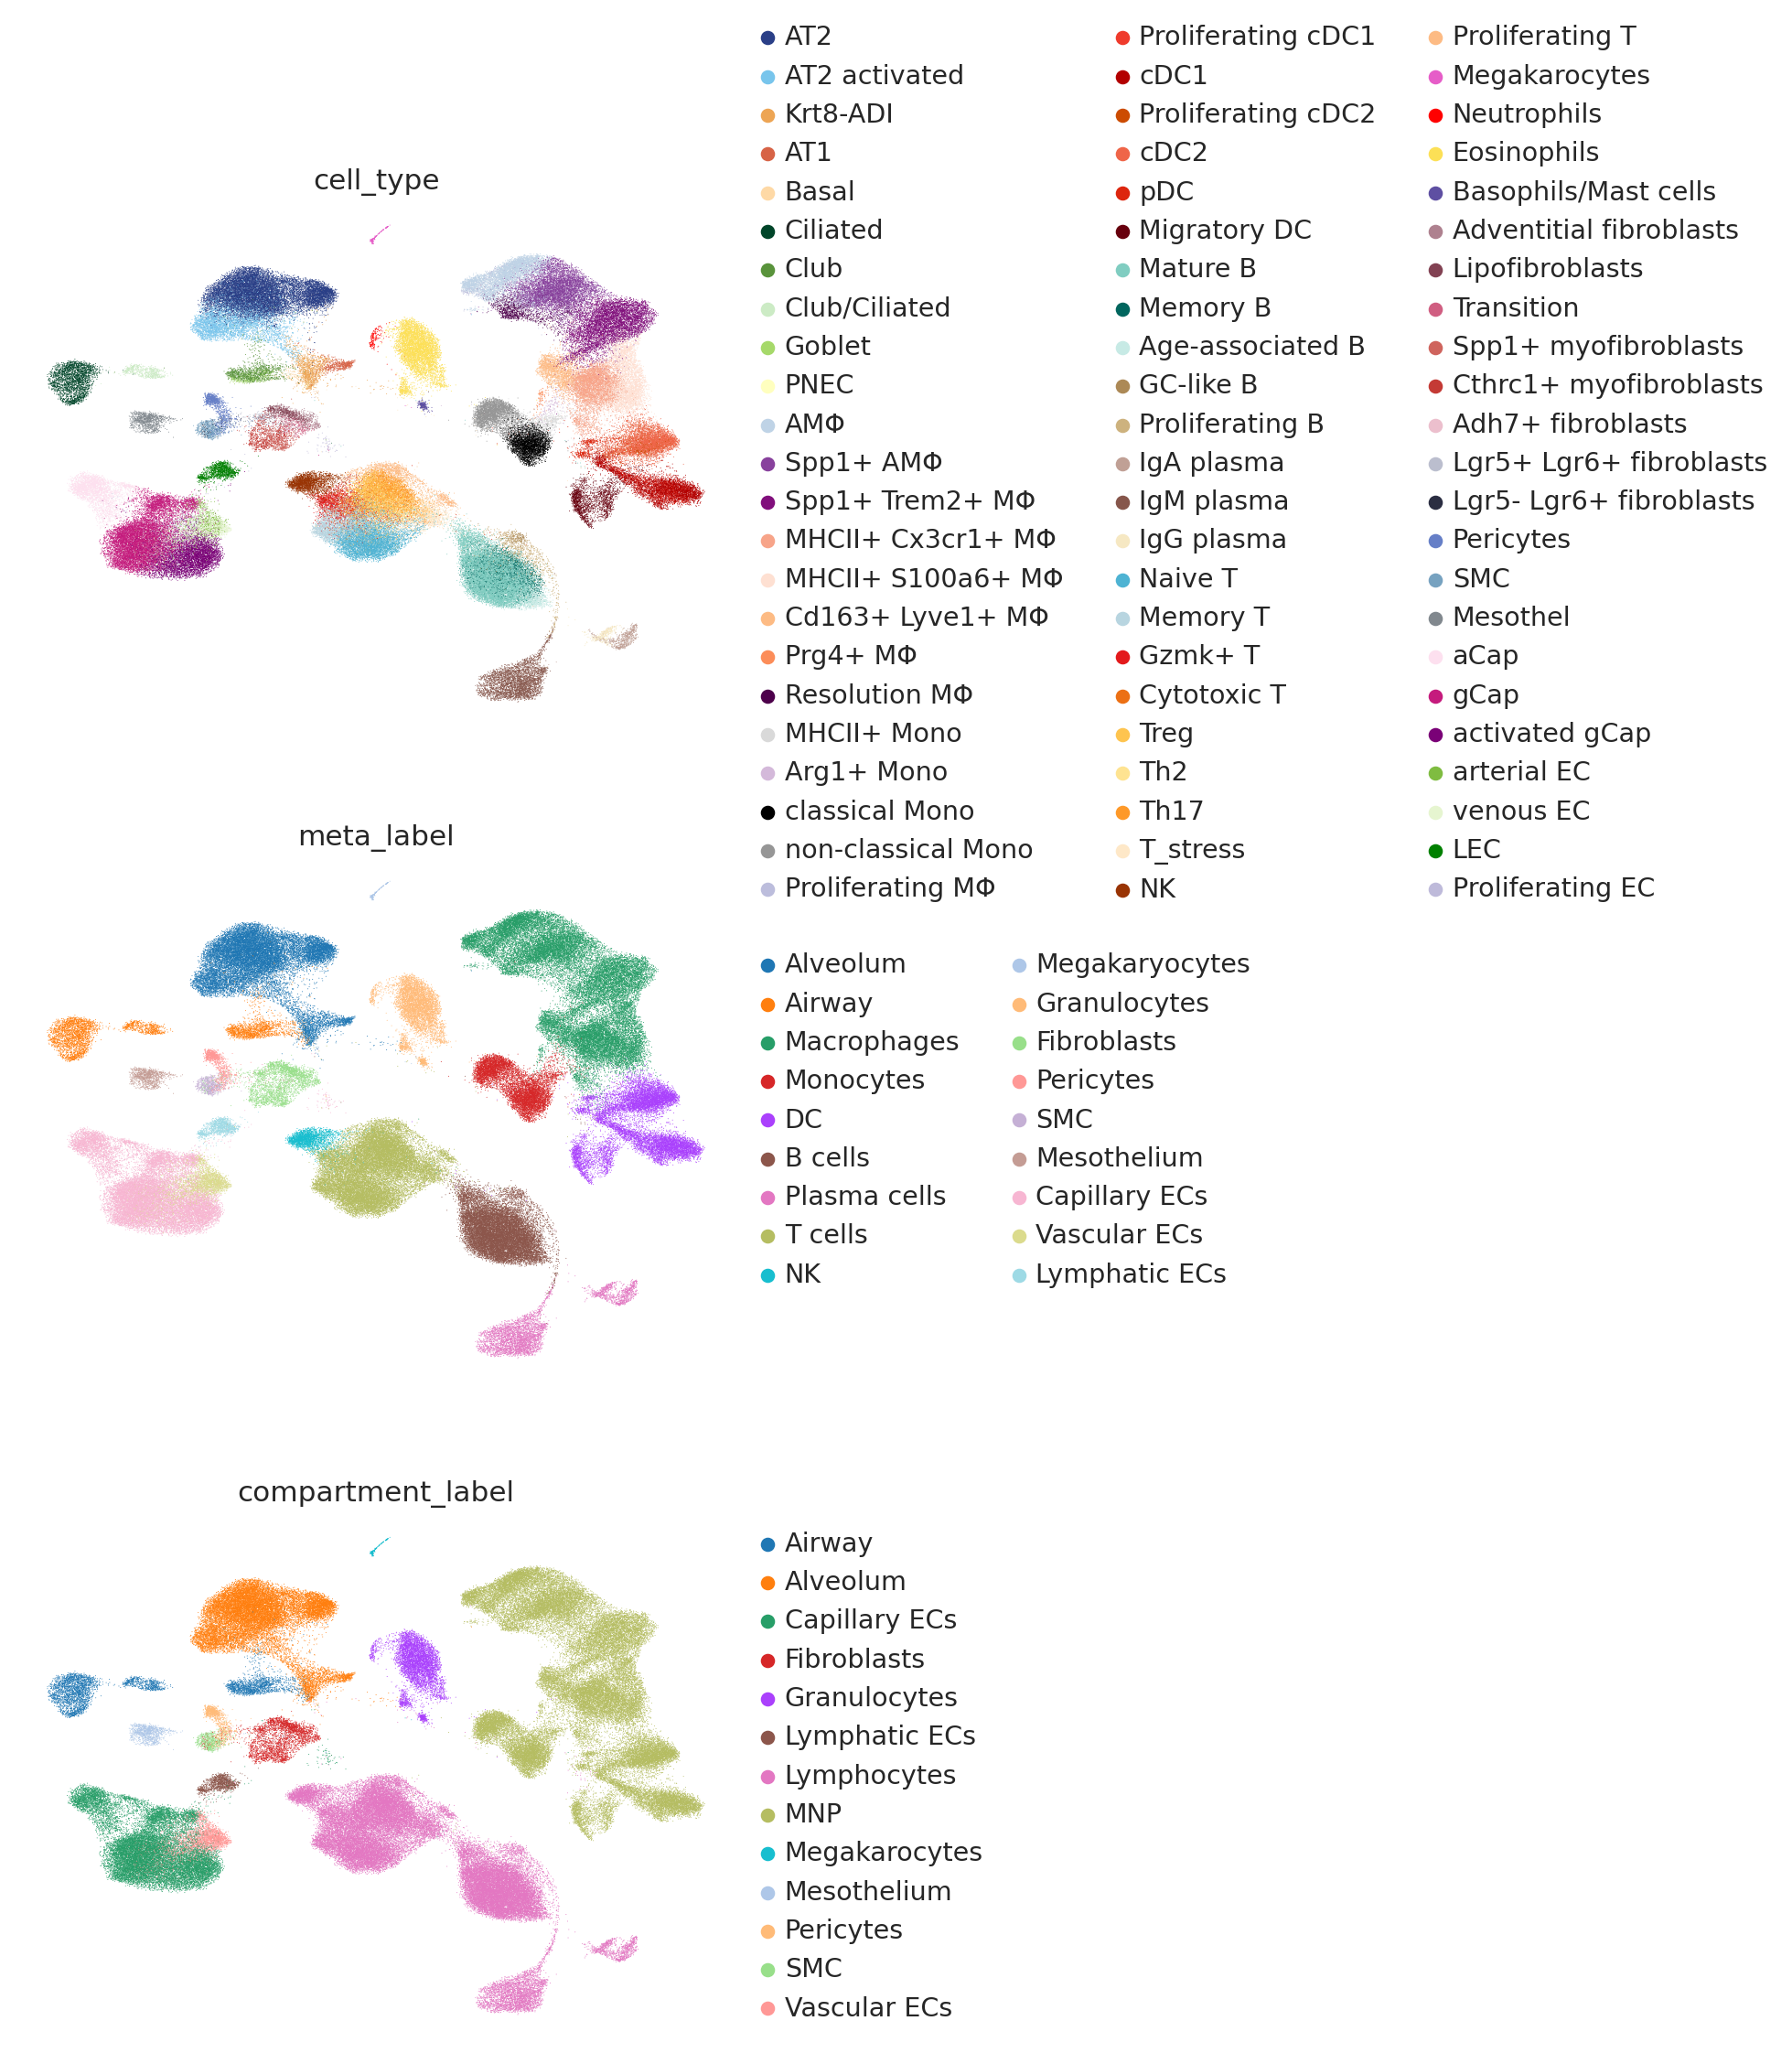

In [7]:
## overview UMAPs
sc.pl.umap(adata, color = ['cell_type','meta_label', 'compartment_label'], ncols = 1, frameon = False)

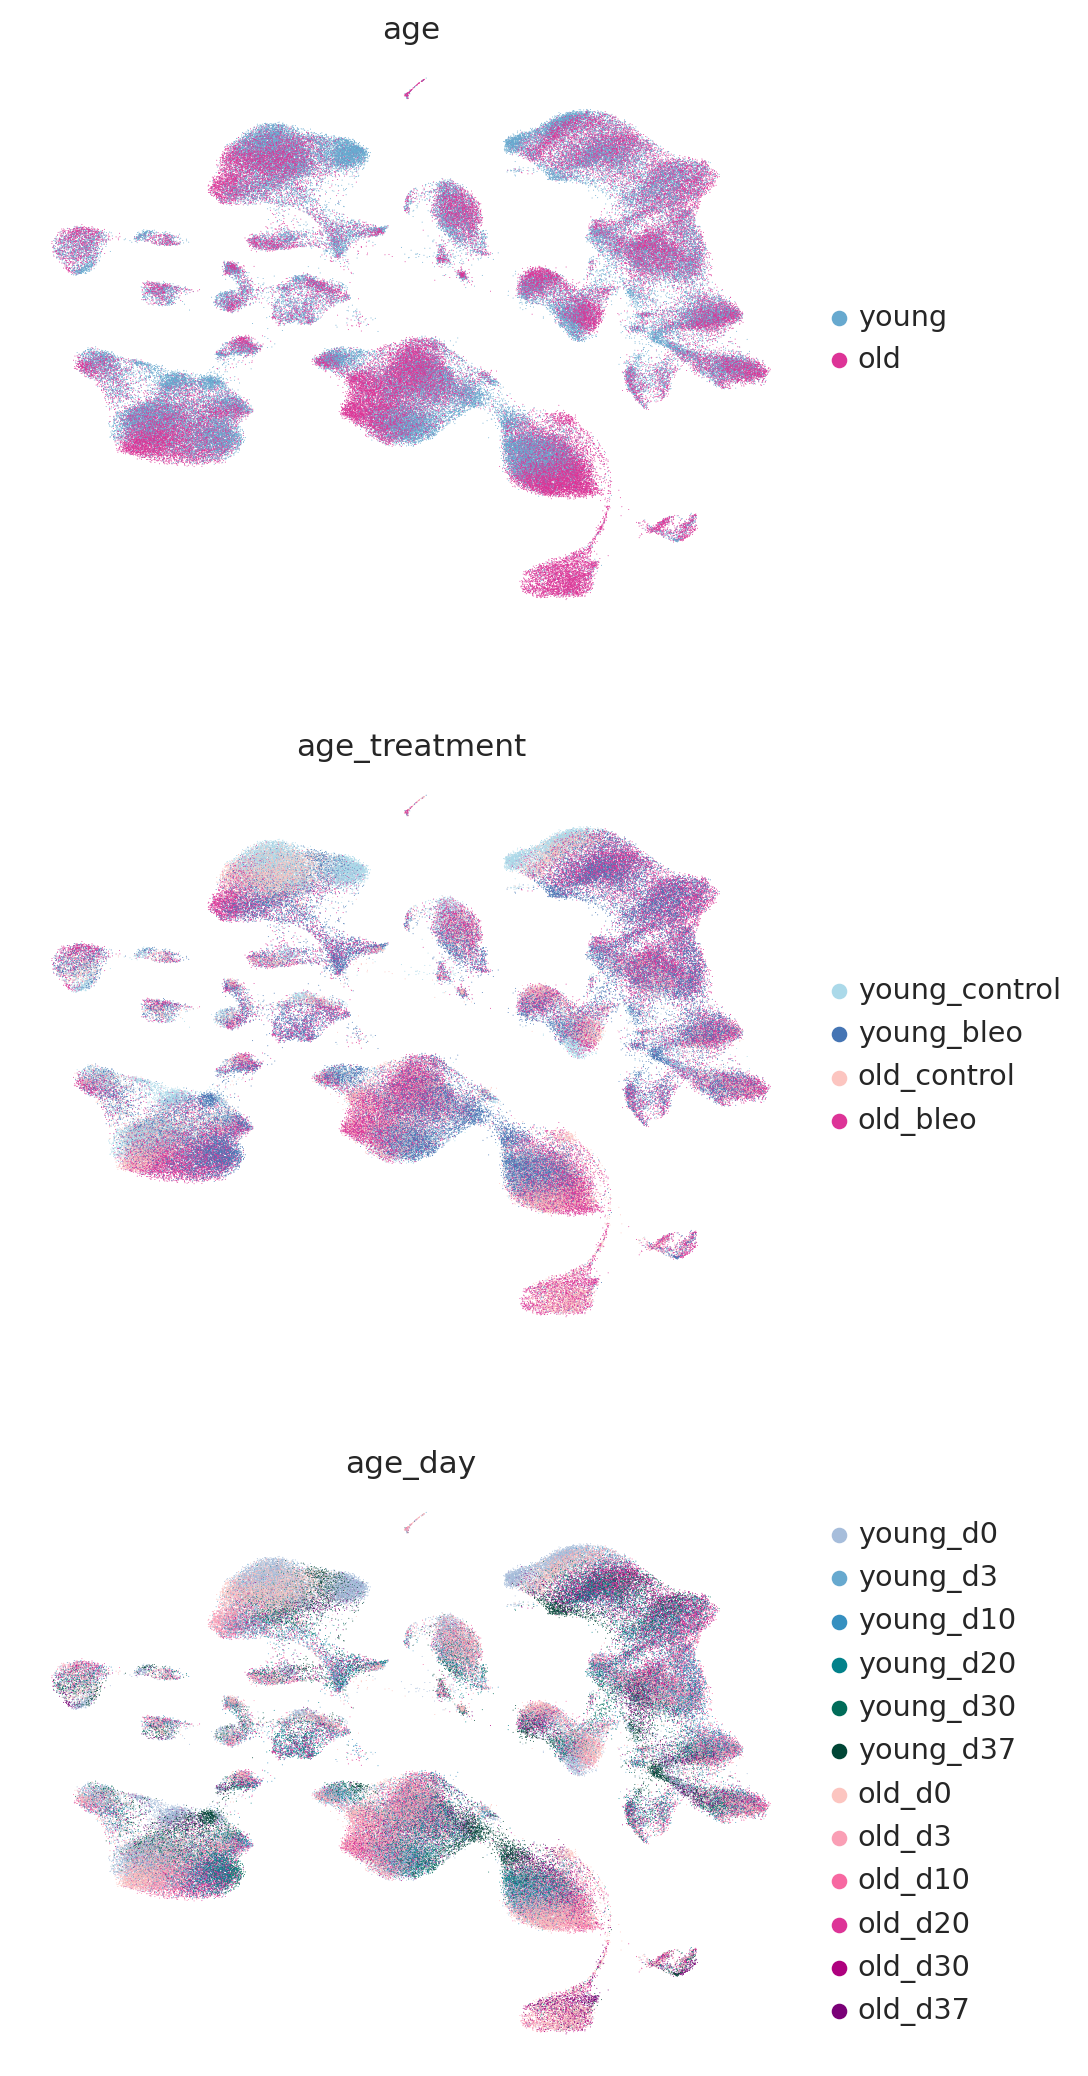

In [8]:
sc.pl.umap(adata, color = ['age','age_treatment', "age_day"], ncols = 1, frameon = False)

In [9]:
adata = adata[-adata.obs.compartment_label.isin(['Megakarocytes'])].copy()

In [10]:
pd.crosstab(adata.obs['age_treatment'],adata.obs['meta_label'])

meta_label     Alveolum  Airway  Macrophages  Monocytes    DC  B cells  \
age_treatment                                                            
young_control      7531    1103         3576       1898  1415     2484   
young_bleo         5016    1494        13181       2024  5365     5271   
old_control        4019     769         2233       1741  1395     3481   
old_bleo           3180    1381        12139       2361  4724     6018   

meta_label     Plasma cells  T cells   NK  Granulocytes  Fibroblasts  \
age_treatment                                                          
young_control            75     2770  667          1303          444   
young_bleo              467     7882  900          1751         1345   
old_control            1643     3599  297          1005          297   
old_bleo               2456     9296  383          1882          960   

meta_label     Pericytes  SMC  Mesothelium  Capillary ECs  Vascular ECs  \
age_treatment                                                             
young_control        225  212          221           4345           583   
young_bleo           386  210          357           6831          1013   
old_control          155  115          191           3075           495   
old_bleo             291  180          297           5724           998   

meta_label     Lymphatic ECs  
age_treatment                 
young_control            165  
young_bleo               438  
old_control              170  
old_bleo                 427

In [11]:
pd.crosstab(adata.obs['age_treatment'],adata.obs['cell_type'])

cell_type       AT2  AT2 activated  Krt8-ADI  AT1  Basal  Ciliated  Club  \
age_treatment                                                              
young_control  7240            173        55   63      4       571   271   
young_bleo     1583           2310       821  302     67       788   407   
old_control    3603            307        40   69     12       386   219   
old_bleo        691           1963       373  153     58       710   387   

cell_type      Club/Ciliated  Goblet  PNEC  ...  Pericytes  SMC  Mesothel  \
age_treatment                               ...                             
young_control            212      39     6  ...        225  212       221   
young_bleo               151      71    10  ...        386  210       357   
old_control               96      54     2  ...        155  115       191   
old_bleo                 143      78     5  ...        291  180       297   

cell_type      aCap  gCap  activated gCap  arterial EC  venous EC  LEC  \
age_treatment                                                            
young_control   813  3322              80          230        353  165   
young_bleo      925  2724            2853          306        707  438   
old_control     497  2323             120          121        374  170   
old_bleo        667  2406            2432          214        784  427   

cell_type      Proliferating EC  
age_treatment                    
young_control               130  
young_bleo                  329  
old_control                 135  
old_bleo                    219  

[4 rows x 68 columns]

In [12]:
## random forest classifier for categorical 'age_treatment' variable
ag_rfc = pt.tl.Augur("random_forest_classifier")

In [13]:
adata.obs.rename(columns = {'cell_type': 'cell_type_resolved'}, inplace=True)

In [15]:
adata = adata[adata.obs.age_treatment.isin(['young_control','young_bleo'])].copy()

In [16]:
adata.obs.age_treatment.value_counts()

age_treatment
young_bleo       53931
young_control    29017
Name: count, dtype: int64

In [17]:
pd.crosstab(adata.obs['age_treatment'],adata.obs['time_point'])

time_point        d0     d3    d10    d20    d30   d37
age_treatment                                         
young_control  29017      0      0      0      0     0
young_bleo         0  10538  11950  11727  11097  8619

In [18]:
adata.obs.time_point

muc26493_TAGACTATTCGG    d0
muc26493_TCCGCTTTACAT    d0
muc26493_CGTGATGGAGTA    d0
muc26493_ATGTGCCCTTGA    d0
muc26493_TTGTTCGCTTGA    d0
                         ..
muc26546_CGGTATTCCAAC    d3
muc26546_CCATACCATCGC    d3
muc26546_ATGAAGACGGGG    d3
muc26546_GTGAGCAAGCTC    d3
muc26546_TAACATACCCAA    d3
Name: time_point, Length: 82948, dtype: category
Categories (6, object): ['d0', 'd3', 'd10', 'd20', 'd30', 'd37']

In [19]:
adata1 = adata[adata.obs.time_point.isin(['d0', 'd3'])].copy()
adata2 = adata[adata.obs.time_point.isin(['d0','d10'])].copy()
adata3 = adata[adata.obs.time_point.isin(['d0','d20'])].copy()
adata4 = adata[adata.obs.time_point.isin(['d0','d30'])].copy()
adata5 = adata[adata.obs.time_point.isin(['d0','d37'])].copy()

In [20]:
loaded_data1 = ag_rfc.load(adata1, label_col="age_treatment", cell_type_col="meta_label")
loaded_data1

AnnData object with n_obs × n_vars = 39555 × 29814
    obs: 'age', 'barcode', 'batch', 'day', 'name', 'sex', 'treatment', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'doublet_scores', 'size_factors', 'S_score', 'G2M_score', 'phase', 'time_point', 'leiden_1', 'leiden_2', 'domain', 'cell_type_resolved', 'ct_level2', 'compartment_label', 'cell_type', 'label', 'age_day', 'y_'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'age_colors', 'age_day_colors', 'age_treatment_colors', 'batch_colors', 'cell_type_colors', 'compartment_label_colors', 'ct_level2_colors', 'day_colors', 'dendrogram_cell_type', 'domain_colors', 'hvg', 'leiden', 'leiden_1_colors', 'leiden_2_colors', 'meta_label_colors', 'neighbors', 'pca', 'sex_colors', 'time_point_colors', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'unsouped_counts'
    obsp: 'connectivities', 

In [21]:
loaded_data1.obs

age barcode          batch day        name     sex  \
muc26493_TAGACTATTCGG  young    N701  ageing_pool_1  d0  yCf_d0_M52  female   
muc26493_TCCGCTTTACAT  young    N701  ageing_pool_1  d0  yCf_d0_M52  female   
muc26493_CGTGATGGAGTA  young    N701  ageing_pool_1  d0  yCf_d0_M52  female   
muc26493_ATGTGCCCTTGA  young    N701  ageing_pool_1  d0  yCf_d0_M52  female   
muc26493_TTGTTCGCTTGA  young    N701  ageing_pool_1  d0  yCf_d0_M52  female   
...                      ...     ...            ...  ..         ...     ...   
muc26546_CGGTATTCCAAC  young    N704  ageing_pool_4  d3   yBm-d3-M4    male   
muc26546_CCATACCATCGC  young    N704  ageing_pool_4  d3   yBm-d3-M4    male   
muc26546_ATGAAGACGGGG  young    N704  ageing_pool_4  d3   yBm-d3-M4    male   
muc26546_GTGAGCAAGCTC  young    N704  ageing_pool_4  d3   yBm-d3-M4    male   
muc26546_TAACATACCCAA  young    N704  ageing_pool_4  d3   yBm-d3-M4    male   

                      treatment identifier  n_counts  n_genes  ...  leiden_1  \
muc26493_TAGACTATTCGG   control   muc26493   14494.0     3719  ...        16   
muc26493_TCCGCTTTACAT   control   muc26493   14156.0     3870  ...        28   
muc26493_CGTGATGGAGTA   control   muc26493   13195.0     3409  ...        16   
muc26493_ATGTGCCCTTGA   control   muc26493   12685.0     4100  ...        28   
muc26493_TTGTTCGCTTGA   control   muc26493   12495.0     2951  ...        16   
...                         ...        ...       ...      ...  ...       ...   
muc26546_CGGTATTCCAAC      bleo   muc26546     427.0      310  ...         1   
muc26546_CCATACCATCGC      bleo   muc26546     427.0      279  ...        13   
muc26546_ATGAAGACGGGG      bleo   muc26546     427.0      325  ...         0   
muc26546_GTGAGCAAGCTC      bleo   muc26546     427.0      330  ...         0   
muc26546_TAACATACCCAA      bleo   muc26546     427.0      303  ...        13   

                       leiden_2       domain  cell_type_resolved  \
muc26493_TAGACTATTCGG        33   Epithelium                Club   
muc26493_TCCGCTTTACAT        40   Epithelium       Club/Ciliated   
muc26493_CGTGATGGAGTA        33   Epithelium              Goblet   
muc26493_ATGTGCCCTTGA        40   Epithelium       Club/Ciliated   
muc26493_TTGTTCGCTTGA        33   Epithelium                Club   
...                         ...          ...                 ...   
muc26546_CGGTATTCCAAC         0   Leukocytes            Mature B   
muc26546_CCATACCATCGC        10   Leukocytes         Eosinophils   
muc26546_ATGAAGACGGGG         2  Endothelium                gCap   
muc26546_GTGAGCAAGCTC         2  Endothelium                gCap   
muc26546_TAACATACCCAA        10   Leukocytes         Eosinophils   

                           ct_level2 compartment_label      cell_type  \
muc26493_TAGACTATTCGG           Club            Airway         Airway   
muc26493_TCCGCTTTACAT  Club/Ciliated            Airway         Airway   
muc26493_CGTGATGGAGTA         Goblet            Airway         Airway   
muc26493_ATGTGCCCTTGA  Club/Ciliated            Airway         Airway   
muc26493_TTGTTCGCTTGA           Club            Airway         Airway   
...                              ...               ...            ...   
muc26546_CGGTATTCCAAC       Mature B       Lymphocytes        B cells   
muc26546_CCATACCATCGC    Eosinophils      Granulocytes   Granulocytes   
muc26546_ATGAAGACGGGG           gCap     Capillary ECs  Capillary ECs   
muc26546_GTGAGCAAGCTC           gCap     Capillary ECs  Capillary ECs   
muc26546_TAACATACCCAA    Eosinophils      Granulocytes   Granulocytes   

                               label   age_day y_  
muc26493_TAGACTATTCGG  young_control  young_d0  1  
muc26493_TCCGCTTTACAT  young_control  young_d0  1  
muc26493_CGTGATGGAGTA  young_control  young_d0  1  
muc26493_ATGTGCCCTTGA  young_control  young_d0  1  
muc26493_TTGTTCGCTTGA  young_control  young_d0  1  
...                              ...       ... ..  
muc26546_CGGTATTCCAAC     young_bleo  young_d3  0  
muc26

In [22]:
loaded_data2 = ag_rfc.load(adata2, label_col="age_treatment", cell_type_col="meta_label")
loaded_data3 = ag_rfc.load(adata3, label_col="age_treatment", cell_type_col="meta_label")
loaded_data4 = ag_rfc.load(adata4, label_col="age_treatment", cell_type_col="meta_label")
loaded_data5 = ag_rfc.load(adata5, label_col="age_treatment", cell_type_col="meta_label")

In [23]:
loaded_data1.var['name'] = loaded_data1.var_names

In [24]:
loaded_data2.var['name'] = loaded_data2.var_names

In [25]:
loaded_data3.var['name'] = loaded_data3.var_names

In [26]:
loaded_data4.var['name'] = loaded_data4.var_names

In [27]:
loaded_data5.var['name'] = loaded_data5.var_names

In [28]:
d3_adata, d3_results = ag_rfc.predict(
    loaded_data1, n_subsamples=50, subsample_size=20, n_threads=32, select_variance_features=True)

d3_results["summary_metrics"]

Set smaller span value in the case of a `segmentation fault` error.

Set larger span in case of svddc or other near singularities error.

Output()

Airway  Mesothelium  Macrophages   T cells  Alveolum  \
mean_augur_score  0.702914     0.682358     0.823628  0.552732  0.837596   
mean_auc          0.702914     0.682358     0.823628  0.552732  0.837596   
mean_accuracy     0.642088     0.590989     0.713333  0.529927  0.719048   
mean_precision    0.629140     0.578162     0.661414  0.532116  0.674085   
mean_f1           0.662576     0.660236     0.765523  0.563366  0.767747   
mean_recall       0.736825     0.815079     0.927460  0.662222  0.915397   

                        DC  Vascular ECs  Plasma cells  Lymphatic ECs  \
mean_augur_score  0.769558      0.585499      0.570488       0.738356   
mean_auc          0.769558      0.585499      0.570488       0.738356   
mean_accuracy     0.658718      0.547289      0.541538       0.629158   
mean_precision    0.630309      0.544264      0.540762       0.611111   
mean_f1           0.717747      0.586161      0.567902       0.681529   
mean_recall       0.861905      0.699048      0.653333       0.807143   

                  Fibroblasts  Capillary ECs   B cells  Monocytes       SMC  \
mean_augur_score     0.733356       0.575102  0.548605   0.583673  0.784626   
mean_auc             0.733356       0.575102  0.548605   0.583673  0.784626   
mean_accuracy        0.652527       0.538462  0.521612   0.546117  0.646740   
mean_precision       0.621117       0.541055  0.515180   0.575504  0.613425   
mean_f1              0.687735       0.568603  0.491810   0.501880  0.715266   
mean_recall          0.823492       0.657778  0.533333   0.509206  0.890635   

                  Pericytes        NK  Granulocytes  
mean_augur_score   0.585283  0.525896      0.614218  
mean_auc           0.585283  0.525896      0.614218  
mean_accuracy      0.532344  0.520110      0.558498  
mean_precision     0.517542  0.524238      0.577472  
mean_f1            0.586955  0.453056      0.526641  
mean_recall        0.721270  0.459206      0.542540

/tmp/ipykernel_2048390/1878953235.py:1: FutureWarning: This function is deprecated and will be removed in pertpy 0.8.0! Please use the corresponding 'pt.tl' object
  pt.pl.ag.lollipop(d3_results)


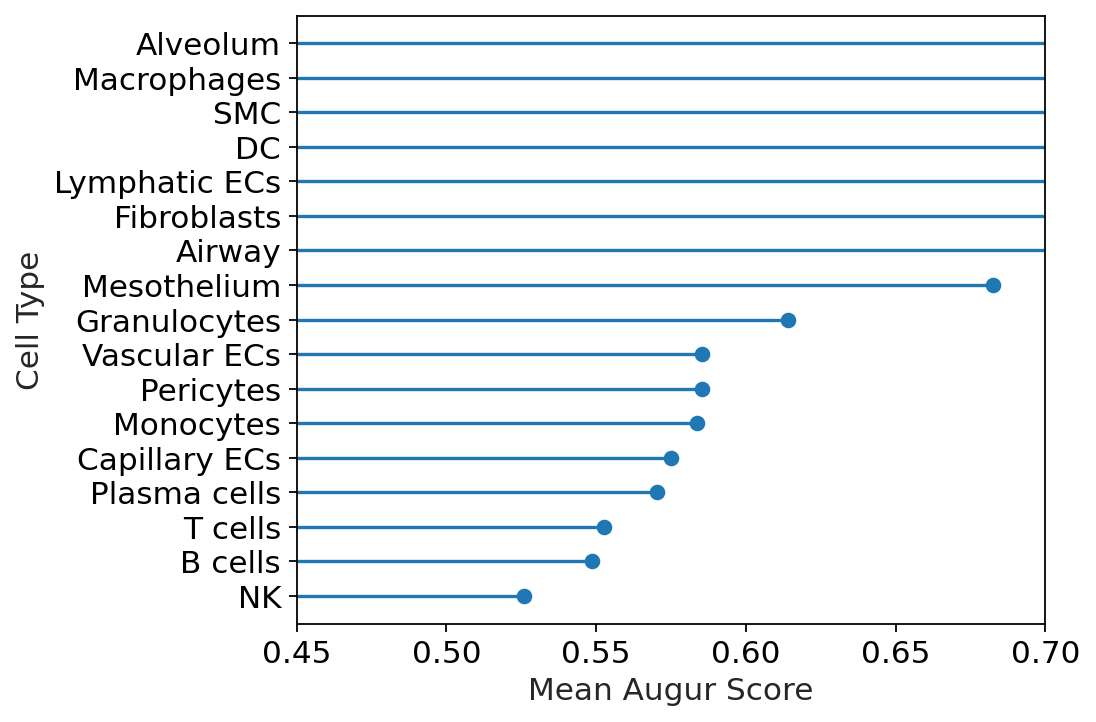

In [29]:
pt.pl.ag.lollipop(d3_results)
plt.xlim([0.45, 0.7])
#plt.yticks(fontsize = 5) 
plt.grid(False)
#plt.savefig(plot_folder + 'pertpy_meta_young.pdf')

/tmp/ipykernel_2048390/2782097142.py:1: FutureWarning: This function is deprecated and will be removed in pertpy 0.8.0! Please use the corresponding 'pt.tl' object
  important_features = pt.pl.ag.important_features(d3_results, top_n=15)


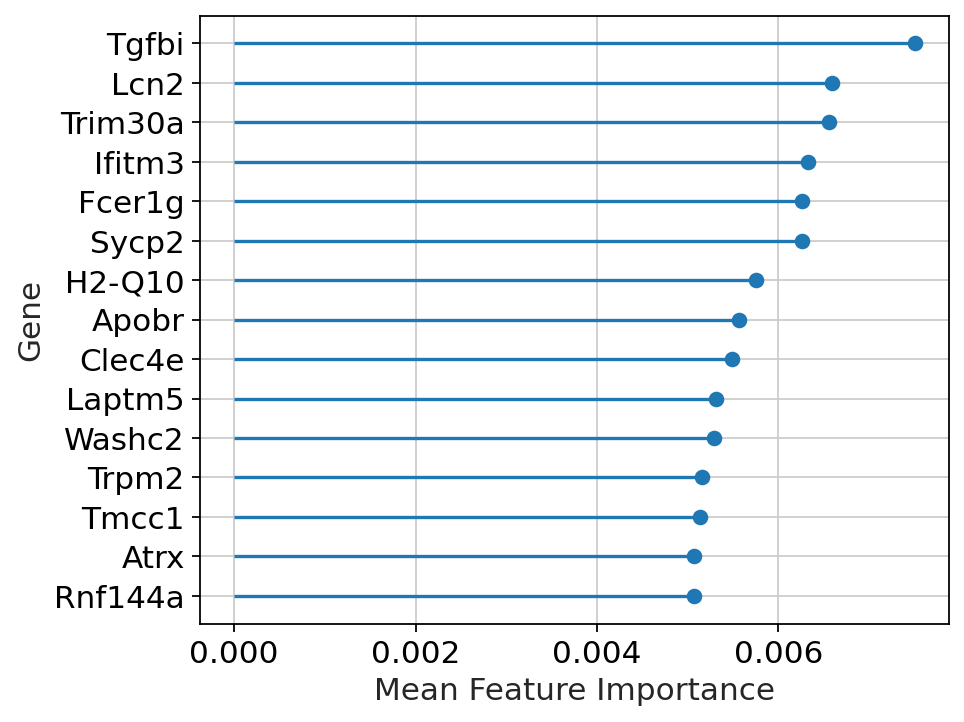

In [30]:
important_features = pt.pl.ag.important_features(d3_results, top_n=15)

In [31]:
d10_adata, d10_results = ag_rfc.predict(
    loaded_data2, n_subsamples=100, subsample_size=20, n_threads=32, select_variance_features=True
)

d10_results['summary_metrics']

Set smaller span value in the case of a `segmentation fault` error.

Set larger span in case of svddc or other near singularities error.

Output()

Airway  Mesothelium  Macrophages   T cells  Alveolum  \
mean_augur_score  0.623583     0.578078     0.767341  0.579133  0.778844   
mean_auc          0.623583     0.578078     0.767341  0.579133  0.778844   
mean_accuracy     0.575604     0.545549     0.660971  0.547015  0.650696   
mean_precision    0.583703     0.553703     0.639238  0.553392  0.610479   
mean_f1           0.559621     0.527823     0.705377  0.548577  0.719905   
mean_recall       0.599048     0.583492     0.827222  0.609603  0.903571   

                        DC  Vascular ECs  Plasma cells  Lymphatic ECs  \
mean_augur_score  0.629592      0.595040      0.543056       0.726190   
mean_auc          0.629592      0.595040      0.543056       0.726190   
mean_accuracy     0.573864      0.554927      0.523498       0.640440   
mean_precision    0.568916      0.574871      0.523981       0.621161   
mean_f1           0.587453      0.547091      0.457480       0.672322   
mean_recall       0.662698      0.594444      0.462222       0.777460   

                  Fibroblasts  Capillary ECs   B cells  Monocytes       SMC  \
mean_augur_score     0.782421       0.675244  0.569824   0.698016  0.659637   
mean_auc             0.782421       0.675244  0.569824   0.698016  0.659637   
mean_accuracy        0.661154       0.607381  0.538205   0.632326  0.585238   
mean_precision       0.622777       0.613802  0.546481   0.718187  0.577346   
mean_f1              0.721153       0.609022  0.462196   0.549080  0.636869   
mean_recall          0.889048       0.664683  0.470238   0.496905  0.758571   

                  Pericytes        NK  Granulocytes  
mean_augur_score   0.662455  0.593486      0.715238  
mean_auc           0.662455  0.593486      0.715238  
mean_accuracy      0.594084  0.550385      0.642381  
mean_precision     0.587129  0.570615      0.691930  
mean_f1            0.593218  0.400154      0.602867  
mean_recall        0.667143  0.351111      0.591190

/tmp/ipykernel_2048390/3717264518.py:1: FutureWarning: This function is deprecated and will be removed in pertpy 0.8.0! Please use the corresponding 'pt.tl' object
  pt.pl.ag.lollipop(d10_results)


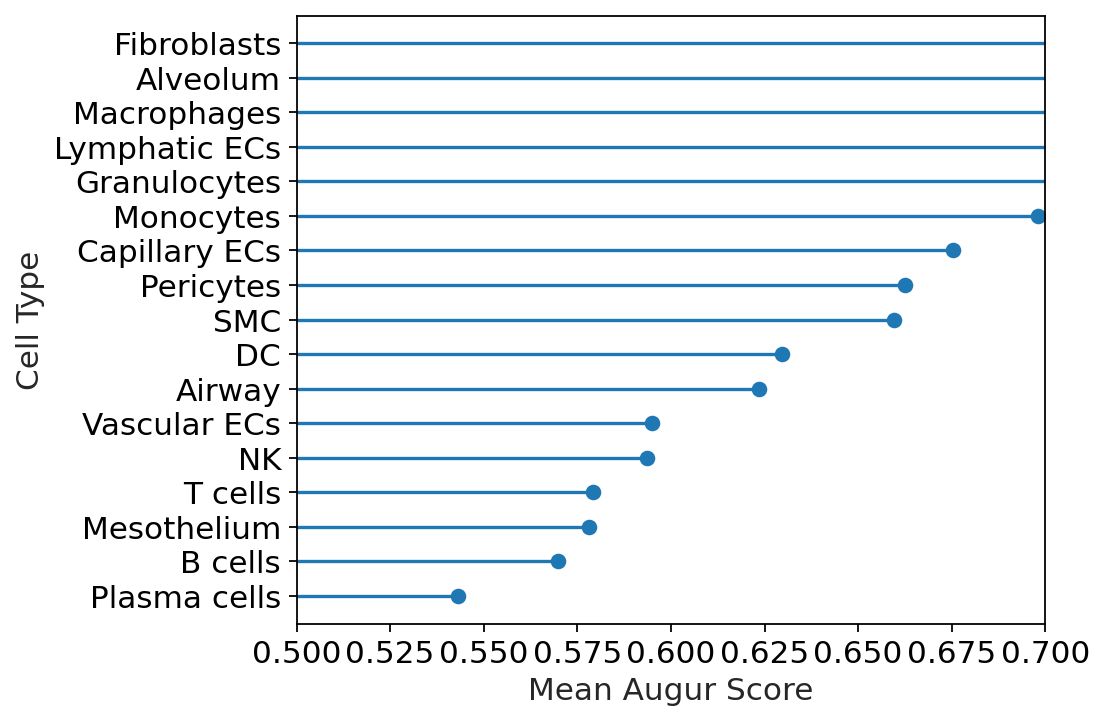

In [32]:
pt.pl.ag.lollipop(d10_results)
plt.xlim([0.5, 0.7])
#plt.yticks(fontsize = 5) 
plt.grid(False)
#plt.savefig(plot_folder + 'pertpy_meta_old.pdf')

/tmp/ipykernel_2048390/404253335.py:1: FutureWarning: This function is deprecated and will be removed in pertpy 0.8.0! Please use the corresponding 'pt.tl' object
  important_features = pt.pl.ag.important_features(d10_results, top_n=15)


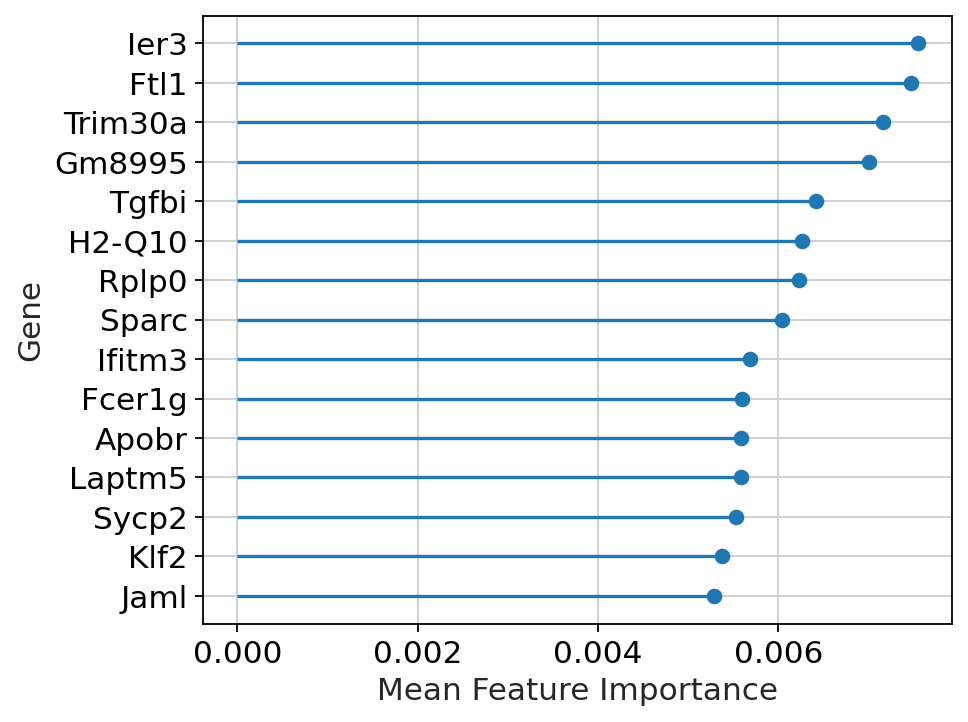

In [33]:
important_features = pt.pl.ag.important_features(d10_results, top_n=15)

In [34]:
d20_adata, d20_results = ag_rfc.predict(
    loaded_data3, n_subsamples=100, subsample_size=20, n_threads=32, select_variance_features=True
)

d20_results['summary_metrics']

Set smaller span value in the case of a `segmentation fault` error.

Set larger span in case of svddc or other near singularities error.

Output()

Airway  Mesothelium  Macrophages   T cells  Alveolum  \
mean_augur_score  0.588946     0.589745     0.739433  0.588974  0.794762   
mean_auc          0.588946     0.589745     0.739433  0.588974  0.794762   
mean_accuracy     0.551960     0.542143     0.655897  0.540385  0.673864   
mean_precision    0.559887     0.544505     0.630994  0.559283  0.633488   
mean_f1           0.526806     0.527002     0.702571  0.423944  0.737494   
mean_recall       0.559762     0.584127     0.828810  0.389286  0.911984   

                        DC  Vascular ECs  Plasma cells  Lymphatic ECs  \
mean_augur_score  0.571259      0.592449      0.533118       0.640402   
mean_auc          0.571259      0.592449      0.533118       0.640402   
mean_accuracy     0.544048      0.555000      0.511593       0.584451   
mean_precision    0.554082      0.570798      0.502364       0.574061   
mean_f1           0.545275      0.467198      0.412137       0.604094   
mean_recall       0.604127      0.461270      0.399048       0.691349   

                  Fibroblasts  Capillary ECs   B cells  Monocytes       SMC  \
mean_augur_score     0.731389       0.670300  0.642336   0.712817  0.580952   
mean_auc             0.731389       0.670300  0.642336   0.712817  0.580952   
mean_accuracy        0.661099       0.599945  0.566832   0.636575  0.544945   
mean_precision       0.640238       0.637772  0.631179   0.722202  0.561544   
mean_f1              0.697907       0.567668  0.409257   0.518714  0.525909   
mean_recall          0.819206       0.579524  0.349206   0.442619  0.566587   

                  Pericytes        NK  Granulocytes  
mean_augur_score   0.545442  0.690918      0.845533  
mean_auc           0.545442  0.690918      0.845533  
mean_accuracy      0.524615  0.575989      0.730311  
mean_precision     0.506709  0.635611      0.880663  
mean_f1            0.413366  0.328863      0.643765  
mean_recall        0.418413  0.241905      0.544683

/tmp/ipykernel_2048390/2650353808.py:1: FutureWarning: This function is deprecated and will be removed in pertpy 0.8.0! Please use the corresponding 'pt.tl' object
  pt.pl.ag.lollipop(d20_results)


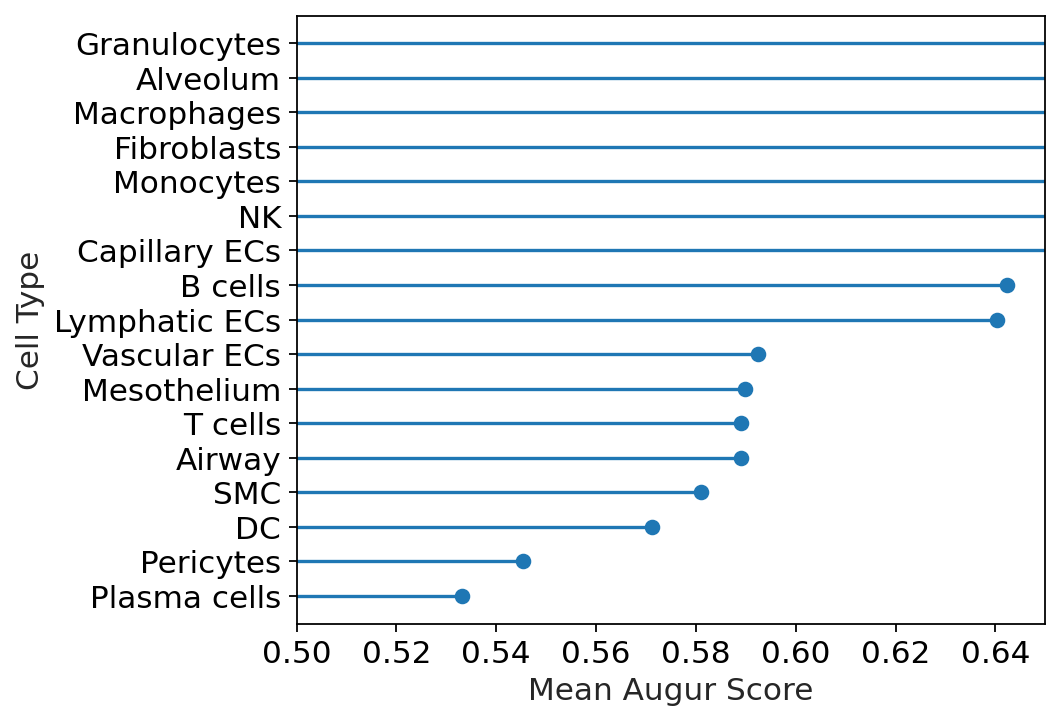

In [35]:
pt.pl.ag.lollipop(d20_results)
plt.xlim([0.5, 0.65])
#plt.yticks(fontsize = 5) 
plt.grid(False)
#plt.savefig(plot_folder + 'pertpy_meta_control.pdf')

/tmp/ipykernel_2048390/927551739.py:1: FutureWarning: This function is deprecated and will be removed in pertpy 0.8.0! Please use the corresponding 'pt.tl' object
  important_features = pt.pl.ag.important_features(d20_results, top_n=15)


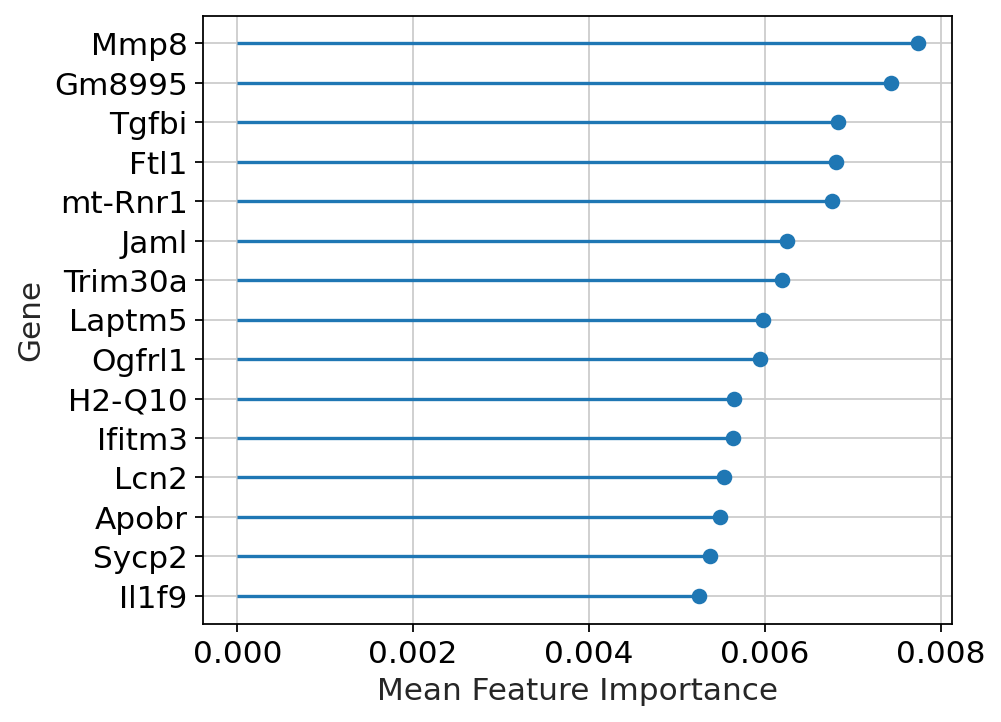

In [36]:
important_features = pt.pl.ag.important_features(d20_results, top_n=15)

In [37]:
d30_adata, d30_results = ag_rfc.predict(
    loaded_data4, n_subsamples=100, subsample_size=20, n_threads=32, select_variance_features=True
)

d30_results['summary_metrics']

Set smaller span value in the case of a `segmentation fault` error.

Set larger span in case of svddc or other near singularities error.

Output()

Airway  Mesothelium  Macrophages   T cells  Alveolum  \
mean_augur_score  0.628186     0.644683     0.782846  0.503889  0.822432   
mean_auc          0.628186     0.644683     0.782846  0.503889  0.822432   
mean_accuracy     0.574817     0.565788     0.688059  0.488938  0.701832   
mean_precision    0.575456     0.555572     0.657012  0.496364  0.659665   
mean_f1           0.583107     0.621655     0.733482  0.495913  0.753378   
mean_recall       0.641508     0.753968     0.860079  0.558651  0.905952   

                        DC  Vascular ECs  Plasma cells  Lymphatic ECs  \
mean_augur_score  0.678617      0.611627      0.580986       0.690006   
mean_auc          0.678617      0.611627      0.580986       0.690006   
mean_accuracy     0.603626      0.573059      0.550733       0.610476   
mean_precision    0.586902      0.569261      0.549723       0.597385   
mean_f1           0.653346      0.597684      0.549695       0.653036   
mean_recall       0.777222      0.680476      0.606190       0.768016   

                  Fibroblasts  Capillary ECs   B cells  Monocytes       SMC  \
mean_augur_score     0.803277       0.669144  0.546315   0.600879  0.702591   
mean_auc             0.803277       0.669144  0.546315   0.600879  0.702591   
mean_accuracy        0.684890       0.606282  0.523388   0.564597  0.596905   
mean_precision       0.640887       0.607682  0.534769   0.597062  0.581329   
mean_f1              0.741314       0.632058  0.504647   0.479140  0.662326   
mean_recall          0.905397       0.711825  0.551508   0.449524  0.805397   

                  Pericytes        NK  Granulocytes  
mean_augur_score   0.638639  0.538027      0.653350  
mean_auc           0.638639  0.538027      0.653350  
mean_accuracy      0.581758  0.516886      0.592582  
mean_precision     0.579099  0.503263      0.609697  
mean_f1            0.608823  0.420158      0.581959  
mean_recall        0.711667  0.421984      0.613968

/tmp/ipykernel_2048390/1699394114.py:1: FutureWarning: This function is deprecated and will be removed in pertpy 0.8.0! Please use the corresponding 'pt.tl' object
  pt.pl.ag.lollipop(d30_results)


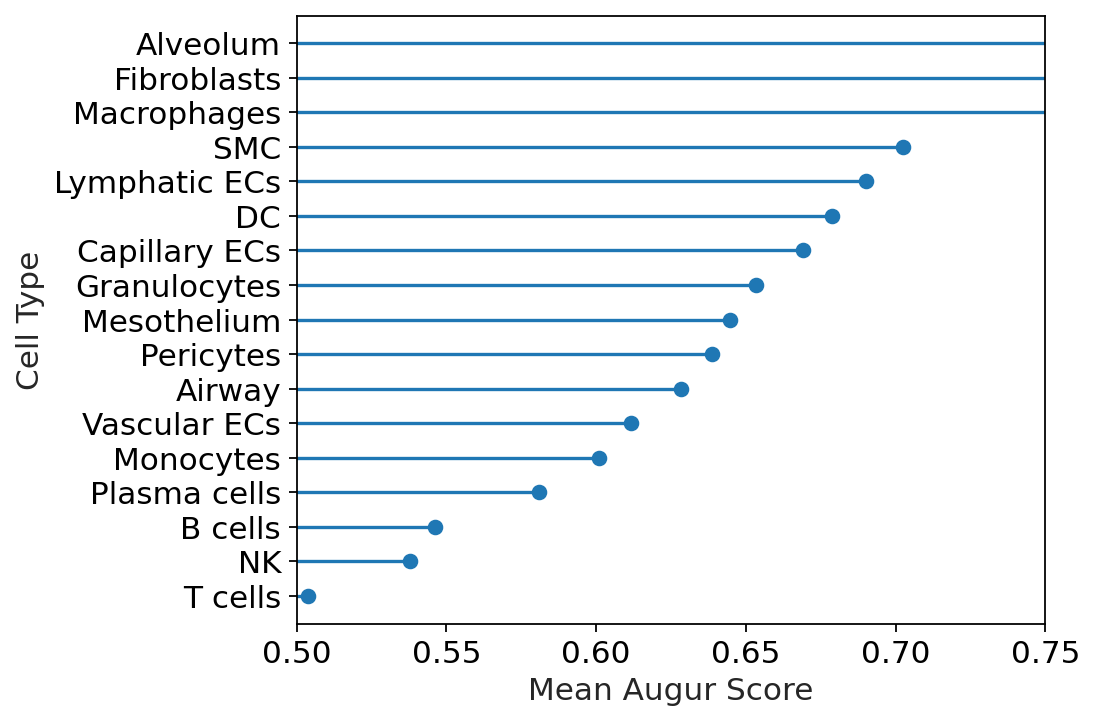

In [38]:
pt.pl.ag.lollipop(d30_results)
plt.xlim([0.5, 0.75])
#plt.yticks(fontsize = 5) 
plt.grid(False)
#plt.savefig(plot_folder + 'pertpy_meta_bleo.pdf')

/tmp/ipykernel_2048390/718609947.py:1: FutureWarning: This function is deprecated and will be removed in pertpy 0.8.0! Please use the corresponding 'pt.tl' object
  important_features = pt.pl.ag.important_features(d30_results, top_n=15)


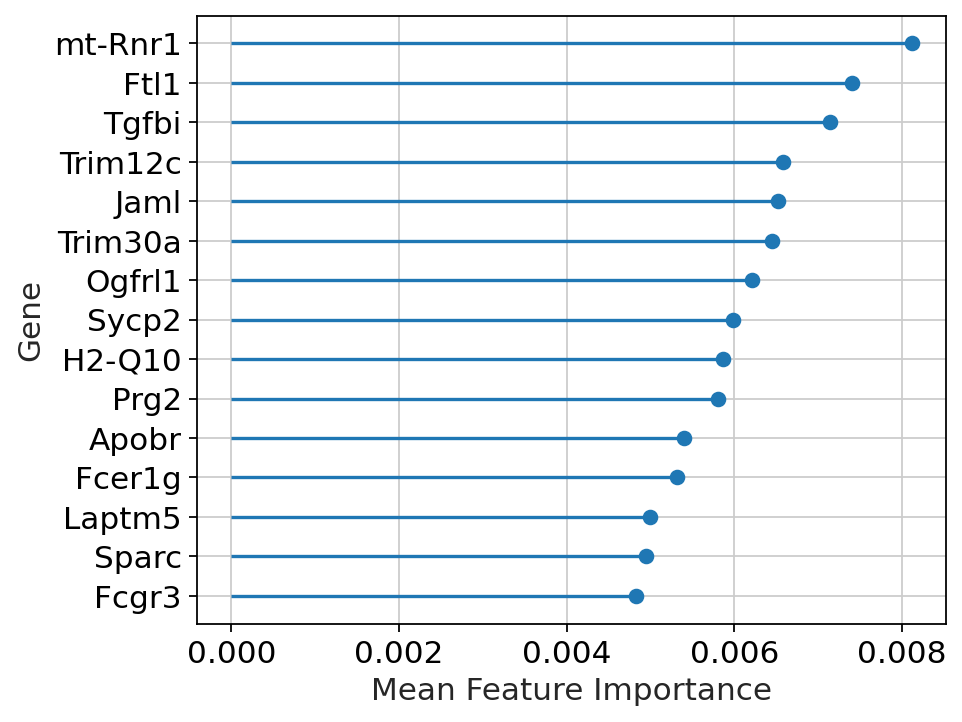

In [39]:
important_features = pt.pl.ag.important_features(d30_results, top_n=15)

In [40]:
d37_adata, d37_results = ag_rfc.predict(
    loaded_data5, n_subsamples=100, subsample_size=20, n_threads=32, select_variance_features=True
)

d37_results['summary_metrics']

Set smaller span value in the case of a `segmentation fault` error.

Set larger span in case of svddc or other near singularities error.

Output()

Airway  Mesothelium  Macrophages   T cells  Alveolum  \
mean_augur_score  0.672296     0.640567     0.680017  0.744467  0.710652   
mean_auc          0.672296     0.640567     0.680017  0.744467  0.710652   
mean_accuracy     0.599029     0.568681     0.601136  0.598736  0.614396   
mean_precision    0.668294     0.602798     0.654670  0.695415  0.681236   
mean_f1           0.480453     0.431447     0.510240  0.380385  0.521035   
mean_recall       0.421032     0.392540     0.468095  0.292381  0.478413   

                        DC  Vascular ECs  Plasma cells  Lymphatic ECs  \
mean_augur_score  0.710300      0.536429      0.727902       0.607336   
mean_auc          0.710300      0.536429      0.727902       0.607336   
mean_accuracy     0.596502      0.513443      0.603773       0.541960   
mean_precision    0.681780      0.527744      0.748690       0.556218   
mean_f1           0.424828      0.416423      0.401884       0.350978   
mean_recall       0.344206      0.396905      0.301508       0.290952   

                  Fibroblasts  Capillary ECs   B cells  Monocytes       SMC  \
mean_augur_score     0.663163       0.706831  0.766695   0.777999  0.847392   
mean_auc             0.663163       0.706831  0.766695   0.777999  0.847392   
mean_accuracy        0.565476       0.605659  0.600128   0.668993  0.640733   
mean_precision       0.591537       0.699737  0.711056   0.809172  0.776933   
mean_f1              0.391989       0.453459  0.390770   0.554438  0.468176   
mean_recall          0.341587       0.368889  0.299365   0.458492  0.361508   

                  Pericytes        NK  Granulocytes  
mean_augur_score   0.613759  0.819155      0.613974  
mean_auc           0.613759  0.819155      0.613974  
mean_accuracy      0.535128  0.601722      0.570916  
mean_precision     0.503790  0.744802      0.602557  
mean_f1            0.264393  0.347511      0.529489  
mean_recall        0.200079  0.244524      0.536746

/tmp/ipykernel_2048390/3721990724.py:1: FutureWarning: This function is deprecated and will be removed in pertpy 0.8.0! Please use the corresponding 'pt.tl' object
  pt.pl.ag.lollipop(d37_results)


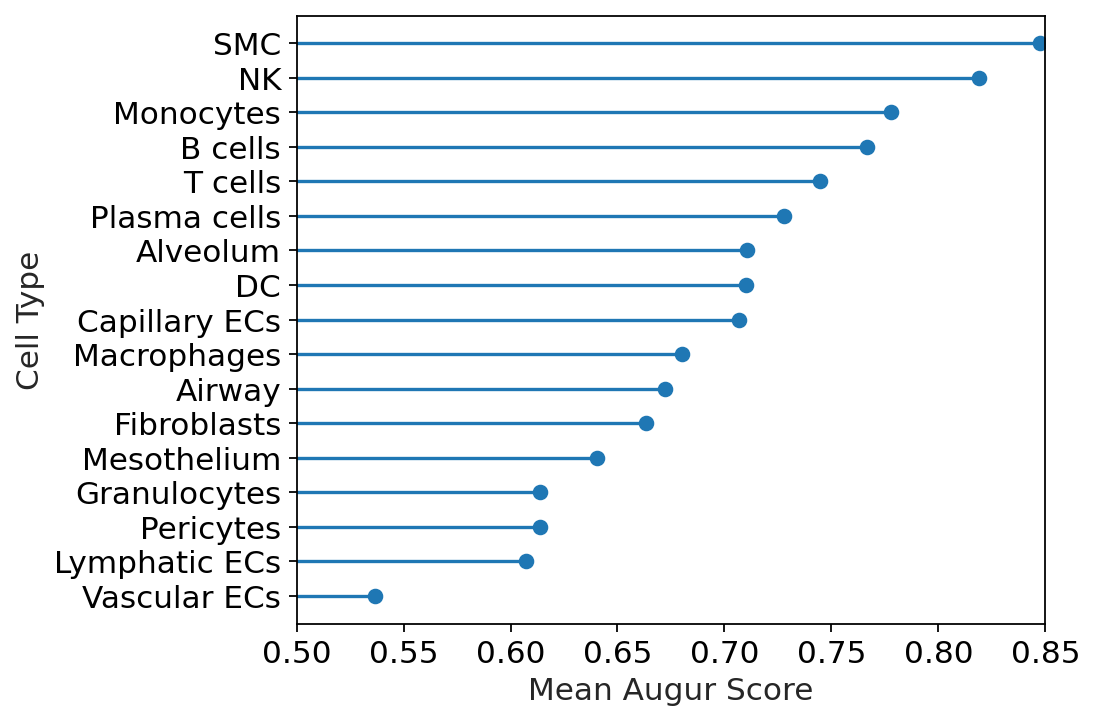

In [41]:
pt.pl.ag.lollipop(d37_results)
plt.xlim([0.5, 0.85])
#plt.yticks(fontsize = 8) 
plt.grid(False)
#plt.savefig(plot_folder + 'pertpy_meta_control.pdf')

/tmp/ipykernel_2048390/82359284.py:1: FutureWarning: This function is deprecated and will be removed in pertpy 0.8.0! Please use the corresponding 'pt.tl' object
  important_features = pt.pl.ag.important_features(d37_results, top_n=15)


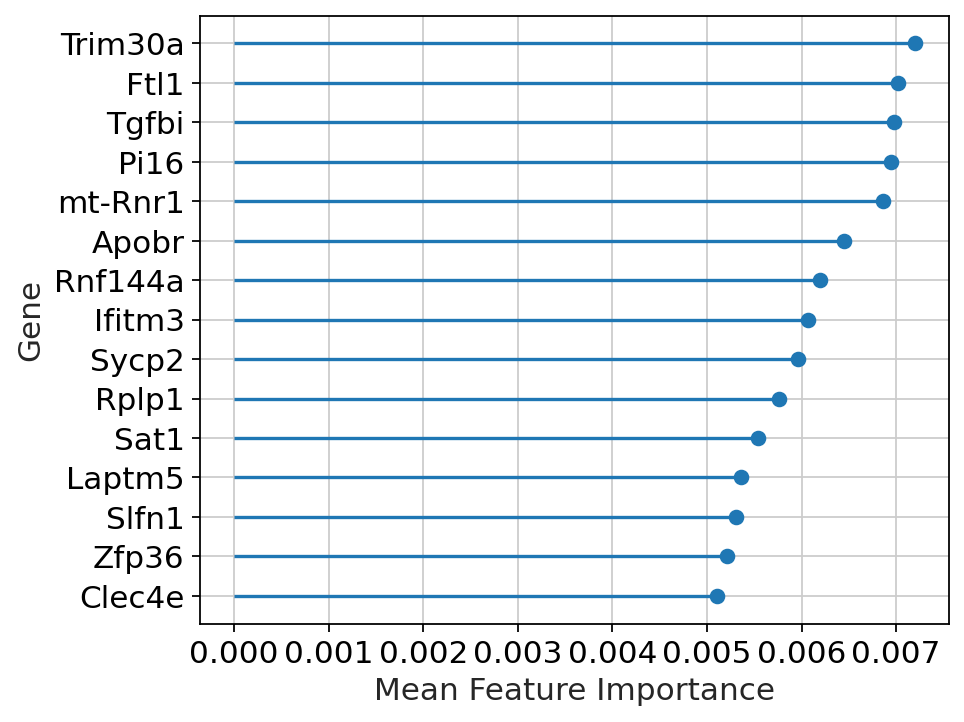

In [42]:
important_features = pt.pl.ag.important_features(d37_results, top_n=15)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:29)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:37)


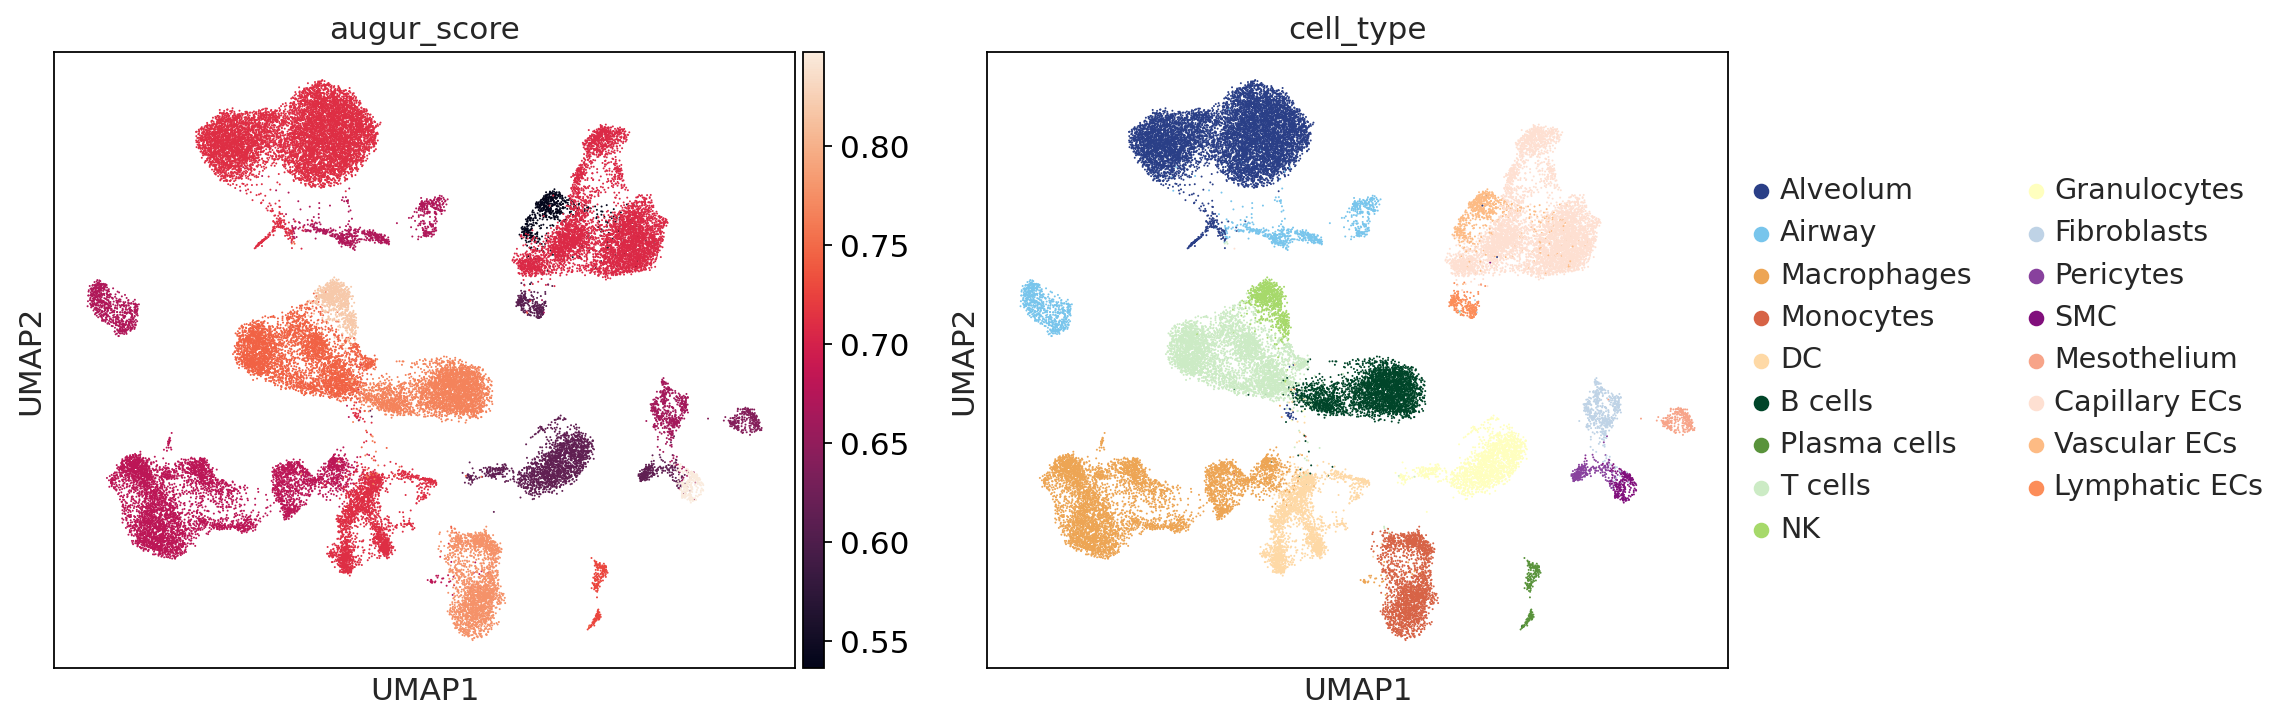

In [52]:
sc.pp.neighbors(d37_adata)
sc.tl.umap(d37_adata)
sc.pl.umap(adata=d37_adata	, color=["augur_score", "cell_type"])

### write augur score tables

In [43]:
d3_scores = d3_results['summary_metrics'].loc['mean_augur_score',]
d10_scores = d10_results['summary_metrics'].loc['mean_augur_score',]
d20_scores = d20_results['summary_metrics'].loc['mean_augur_score',]
d30_scores = d30_results['summary_metrics'].loc['mean_augur_score',]
d37_scores = d37_results['summary_metrics'].loc['mean_augur_score',]

In [44]:
d3_scores = pd.DataFrame(d3_scores)
d10_scores = pd.DataFrame(d10_scores)
d20_scores = pd.DataFrame(d20_scores)
d30_scores = pd.DataFrame(d30_scores)
d37_scores = pd.DataFrame(d37_scores)

In [45]:
d3_scores.columns = ['d3']
d10_scores.columns = ['d10']
d20_scores.columns = ['d20']
d30_scores.columns = ['d30']
d37_scores.columns = ['d37']

In [47]:
#all_timpoint_scores = [d0_df, d3_scores, d10_scores, d20_scores, d30_scores, d37_scores]
time_point_scores = pd.concat([d3_scores, d10_scores, d20_scores, d30_scores, d37_scores], axis = 1)#, sort = False)
time_point_scores

d3       d10       d20       d30       d37
Airway         0.702914  0.623583  0.588946  0.628186  0.672296
Mesothelium    0.682358  0.578078  0.589745  0.644683  0.640567
Macrophages    0.823628  0.767341  0.739433  0.782846  0.680017
T cells        0.552732  0.579133  0.588974  0.503889  0.744467
Alveolum       0.837596  0.778844  0.794762  0.822432  0.710652
DC             0.769558  0.629592  0.571259  0.678617  0.710300
Vascular ECs   0.585499  0.595040  0.592449  0.611627  0.536429
Plasma cells   0.570488  0.543056  0.533118  0.580986  0.727902
Lymphatic ECs  0.738356  0.726190  0.640402  0.690006  0.607336
Fibroblasts    0.733356  0.782421  0.731389  0.803277  0.663163
Capillary ECs  0.575102  0.675244  0.670300  0.669144  0.706831
B cells        0.548605  0.569824  0.642336  0.546315  0.766695
Monocytes      0.583673  0.698016  0.712817  0.600879  0.777999
SMC            0.784626  0.659637  0.580952  0.702591  0.847392
Pericytes      0.585283  0.662455  0.545442  0.638639  0.613759
NK             0.525896  0.593486  0.690918  0.538027  0.819155
Granulocytes   0.614218  0.715238  0.845533  0.653350  0.613974

In [48]:
## Save the Marker Table
out_folder = "/media/HDD_1/Michael/Michelangelo/aging/augurpy/"
time_point_scores.to_csv(out_folder + "time_resolved_augur_scores_young.txt", sep = "\t")